# Jeu de la vie

In [1]:
%matplotlib inline
import timeit
import matplotlib.pylab as plt
import numpy as np
from numba import jit, njit, cuda, prange, uint16, int32
import math
import random
from tqdm.notebook import tqdm

plt.style.use('ggplot')

## Fonctions utilitaires

Quelques fonctions sont définies pour rpou initialiser les données et sauvegarder le résultat des simulations.

In [2]:
def constructions(X,Y,T):
    monde = np.zeros((T,X,Y), dtype=np.uint16)    
    return monde

def initialiser(monde, seuil=0.25):
    monde[0,:,:] = (np.random.rand(monde.shape[1],monde.shape[2])>seuil)*1

def afficher_image(image,i):
    plt.figure(figsize=(10,10))
    plt.imshow(image[i,:,:].T, origin='lower',  vmin=0, vmax=5)    
    plt.grid(False)
    plt.title("Génération %02d"%(i,))
    plt.show()

def sauvegarder_images(monde, nom="monde"):
    for t in range(1,monde.shape[0]):   
        plt.figure(figsize=(10,10))
        plt.imshow(monde[t,:,:].T, origin='lower',  vmin=0, vmax=5)    
        plt.grid(False)
        plt.title("Génération %02d"%(t,))
        plt.savefig("fig/%s_%03d.png"%(nom,t))
        plt.close()

## Règle du jeu de la vie
 
Comme il est présenté dans l'article, on utilise des règles modifiées par rapport au jeu de lavie initialement décrit par Conway. De plus chaque cellule contient son age.

In [3]:
def evoluer(monde):
    for t in range(1,monde.shape[0]):     
        for x in range(1,monde.shape[1]-1):
            for y in range(1,monde.shape[2]-1):
                somme = 0
                if monde[t-1,x-1,y-1]>0:
                    somme +=1
                if monde[t-1,x,y-1]>0:
                    somme +=1
                if monde[t-1,x+1,y-1]>0:
                    somme +=1
                
                if monde[t-1,x-1,y]>0:
                    somme +=1
                if monde[t-1,x+1,y]>0:
                    somme +=1
                    
                if monde[t-1,x-1,y+1]>0:
                    somme +=1
                if monde[t-1,x,y+1]>0:
                    somme +=1
                if monde[t-1,x+1,y+1]>0:
                    somme +=1

                if (somme==3) or (somme==4):
                    monde[t,x,y] = monde[t-1,x,y] + 1
                else:
                    monde[t,x,y] = 0

## Implémenation avec Numba

Le portage en Numba sur CPU se fait en ajoutant simplement le décorateur

In [4]:
@njit(cache=True)
def evoluer_numba(monde):
    for t in range(1,monde.shape[0]):     
        for x in range(1,monde.shape[1]-1):
            for y in range(1,monde.shape[2]-1):
                somme = 0
                if monde[t-1,x-1,y-1]>0:
                    somme +=1
                if monde[t-1,x,y-1]>0:
                    somme +=1
                if monde[t-1,x+1,y-1]>0:
                    somme +=1
                
                if monde[t-1,x-1,y]>0:
                    somme +=1
                if monde[t-1,x+1,y]>0:
                    somme +=1
                    
                if monde[t-1,x-1,y+1]>0:
                    somme +=1
                if monde[t-1,x,y+1]>0:
                    somme +=1
                if monde[t-1,x+1,y+1]>0:
                    somme +=1

                if (somme==3) or (somme==4):
                    monde[t,x,y] = monde[t-1,x,y] + 1
                else:
                    monde[t,x,y] = 0

## Implémentations utilisant la carte graphique

Le premier kernel est l'application directe des règles du jeu de la vie. A chaque appel, l'intégralité du "monde" de jeu est transféré vers la carte graphique.

In [5]:
NB_THREADS = 32

@cuda.jit
def kernel_cuda(monde, t):    
    x, y = cuda.grid(2)            
    _, n, m = monde.shape
    if 1 <= x < (n-1) and 1 <= y < (m-1) :

        somme = 0
        if monde[t-1,x-1,y-1]>0:
            somme +=1
        if monde[t-1,x,y-1]>0:
            somme +=1
        if monde[t-1,x+1,y-1]>0:
            somme +=1

        if monde[t-1,x-1,y]>0:
            somme +=1
        if monde[t-1,x+1,y]>0:
            somme +=1

        if monde[t-1,x-1,y+1]>0:
            somme +=1
        if monde[t-1,x,y+1]>0:
            somme +=1
        if monde[t-1,x+1,y+1]>0:
            somme +=1      
        
        if (somme==3) or (somme==4):
            monde[t,x,y] = monde[t-1,x,y] + 1
        else:
            monde[t,x,y] = 0

        
def evoluer_numba_cuda(monde):    
    threadsperblock = (NB_THREADS, NB_THREADS)            
    blockspergrid_x = math.ceil(monde.shape[1] / threadsperblock[0])
    blockspergrid_y = math.ceil(monde.shape[2] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)    
    for t in range(1,monde.shape[0]):    
        kernel_cuda[blockspergrid, threadsperblock](monde, t)

Pour éviter des transferts inutiles, les données ne sont envoyées qu'une seule fois vers la carte graphique en utilisant les instructions `to_device` et `copy_to_host`.

In [6]:
@cuda.jit
def kernel_cuda_device(d_monde, t):    
    x, y = cuda.grid(2)            
    _, n, m = d_monde.shape
    if 1 <= x < (n-1) and 1 <= y < (m-1) :
        somme = 0
        if d_monde[t-1,x-1,y-1]>0:
            somme +=1
        if d_monde[t-1,x,y-1]>0:
            somme +=1
        if d_monde[t-1,x+1,y-1]>0:
            somme +=1

        if d_monde[t-1,x-1,y]>0:
            somme +=1
        if d_monde[t-1,x+1,y]>0:
            somme +=1

        if d_monde[t-1,x-1,y+1]>0:
            somme +=1
        if d_monde[t-1,x,y+1]>0:
            somme +=1
        if d_monde[t-1,x+1,y+1]>0:
            somme +=1      
        
        if (somme==3) or (somme==4):
            d_monde[t,x,y] = d_monde[t-1,x,y] + 1
        else:
            d_monde[t,x,y] = 0
    

        
def evoluer_numba_cuda_device(monde):    
    threadsperblock = (NB_THREADS, NB_THREADS)            
    blockspergrid_x = math.ceil(monde.shape[1] / threadsperblock[0])
    blockspergrid_y = math.ceil(monde.shape[2] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)    
    d_monde = cuda.to_device(monde)
    for t in range(1,monde.shape[0]):    
        kernel_cuda_device[blockspergrid, threadsperblock](d_monde, t)
    d_monde.copy_to_host(monde)    

Pour minimiser les opérations d'accès à la mémoire principale de la carte graphique, les données sont copiées dans la mémoire partagées par les _threads_ avant les calculs.

In [7]:
@cuda.jit
def kernel_cuda_device_shared(d_monde, t):    
    tmp_array = cuda.shared.array(shape=(32+1+1, 32+1+1), dtype=uint16)
    
    x, y = cuda.grid(2)         
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    _, n, m = d_monde.shape
        
    # Remplissage de la mémoire partagée
    if 0 <= x < n and 0 <= y < m : 
        
        tmp_array[tx+1, ty+1] = d_monde[t-1,x,y]
                
        # Colonne de gauche
        if tx==0 and (x-1)>=0:
            tmp_array[tx, ty+1] = d_monde[t-1,x-1,y]        
        # Colonne de droite
        if tx==cuda.blockDim.x-1 and (x+1)<n:
            tmp_array[tx+2, ty+1] = d_monde[t-1,x+1,y] 

        # Ligne supérieure
        if ty==0 and y>0:
            tmp_array[tx+1, 0] = d_monde[t-1,x,y-1]
            # Coin gauche
            if tx==0 and x>0:
                tmp_array[tx, ty] = d_monde[t-1,x-1,y-1]
           # Coin droit
            if tx==cuda.blockDim.x-1 and (x+1)<n:
                tmp_array[tx+2, ty] = d_monde[t-1,x+1,y-1]
        
        # Ligne inférieure
        if ty==cuda.blockDim.y-1 and (y+1)<m:
            tmp_array[tx+1, ty+2] = d_monde[t-1,x,y+1]
            # Coin gauche
            if tx==0 and x>0:
                tmp_array[tx, ty+2] = d_monde[t-1,x-1,y+1]
            # Coin droit
            if tx==cuda.blockDim.x-1 and (x+1)<n:
                tmp_array[tx+2, ty+2] = d_monde[t-1,x+1,y+1]
          
        cuda.syncthreads()    

        # Mise à jour du voisinnage    
        somme = 0
        if tmp_array[tx,ty]>0:
            somme +=1
        if tmp_array[tx+1,ty]>0:
            somme +=1
        if tmp_array[tx+2,ty]>0:
            somme +=1

        if tmp_array[tx,ty+1]>0:
            somme +=1
        if tmp_array[tx+2,ty+1]>0:
            somme +=1

        if tmp_array[tx,ty+2]>0:
            somme +=1
        if tmp_array[tx+1,ty+2]>0:
            somme +=1
        if tmp_array[tx+2,ty+2]>0:
            somme +=1      

            
    if 1 <= x < (n-1) and 1 <= y < (m-1) :         
        if (somme==3) or (somme==4):
            d_monde[t,x,y] = tmp_array[tx+1, ty+1] + 1
        else:
            d_monde[t,x,y] = 0
   
        
def evoluer_numba_cuda_device_shared(monde):    
    threadsperblock = (32, 32)            
    blockspergrid_x = math.ceil(monde.shape[1] / threadsperblock[0])
    blockspergrid_y = math.ceil(monde.shape[2] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)   
    d_monde = cuda.to_device(monde)
    for t in range(1,monde.shape[0]):    
        kernel_cuda_device_shared[blockspergrid, threadsperblock](d_monde, t)
    d_monde.copy_to_host(monde)  

In [8]:
NB_REPET = 10
TAILLE = 1000
generations = range(2,50) # 10h de calculs...

temps_calculs = np.zeros((5,len(generations)))

for t in tqdm(generations , desc="Nombre du images" ):
    
    monde = constructions(TAILLE,TAILLE,t)
    initialiser(monde,0.25)
            
    monde_python = np.array(monde)
    temps = timeit.timeit("evoluer(monde_python)", setup="from __main__ import evoluer, monde_python",  number=1)     
    temps_calculs[0, generations.index(t)] = temps
        
    monde_numba = np.array(monde)
    temps = timeit.timeit("evoluer_numba(monde_numba)", setup="from __main__ import evoluer_numba, monde_numba",  number=NB_REPET)     
    temps_calculs[1, generations.index(t)] = temps/NB_REPET    
        
    monde_numba_gpu = np.array(monde)
    temps = timeit.timeit("evoluer_numba_cuda(monde_numba_gpu)", setup="from __main__ import evoluer_numba_cuda, monde_numba_gpu",  number=NB_REPET)     
    temps_calculs[2, generations.index(t)] = temps/NB_REPET      

    monde_numba_gpu_device = np.array(monde)
    temps = timeit.timeit("evoluer_numba_cuda_device(monde_numba_gpu_device)", setup="from __main__ import evoluer_numba_cuda_device, monde_numba_gpu_device",  number=NB_REPET)     
    temps_calculs[3, generations.index(t)] = temps/NB_REPET      
        
    monde_numba_gpu_shared = np.array(monde)
    temps = timeit.timeit("evoluer_numba_cuda_device_shared(monde_numba_gpu_shared)", setup="from __main__ import evoluer_numba_cuda_device_shared, monde_numba_gpu_shared",  number=NB_REPET)     
    temps_calculs[4, generations.index(t)] = temps/NB_REPET      

np.save("CalculsGenerations", temps_calculs)    

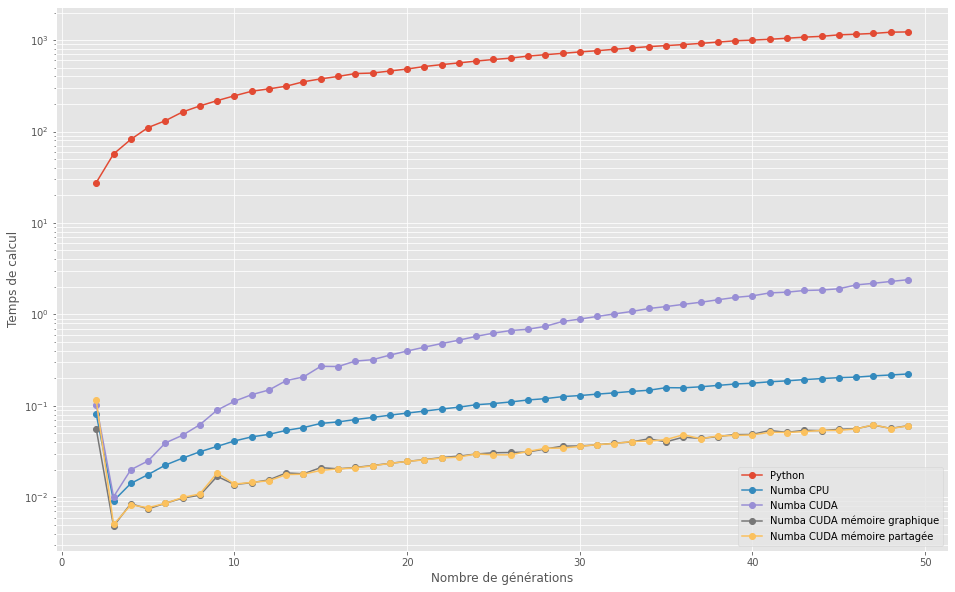

In [9]:
plt.figure(figsize=(16,10))    
plt.semilogy(generations,temps_calculs[0,:], marker="o")
plt.semilogy(generations,temps_calculs[1,:], marker="o")
plt.semilogy(generations,temps_calculs[2,:], marker="o")
plt.semilogy(generations,temps_calculs[3,:], marker="o")
plt.semilogy(generations,temps_calculs[4,:], marker="o")
plt.legend(("Python", "Numba CPU","Numba CUDA","Numba CUDA mémoire graphique","Numba CUDA mémoire partagée"))
plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')
plt.xlabel("Nombre de générations")
plt.ylabel("Temps de calcul")
plt.show()

Sur la GeForce RTX 2060 l'utilisation de la mémoire partagée n'améliore pas le temps de calcul contraitement à GeForce GTX 960.

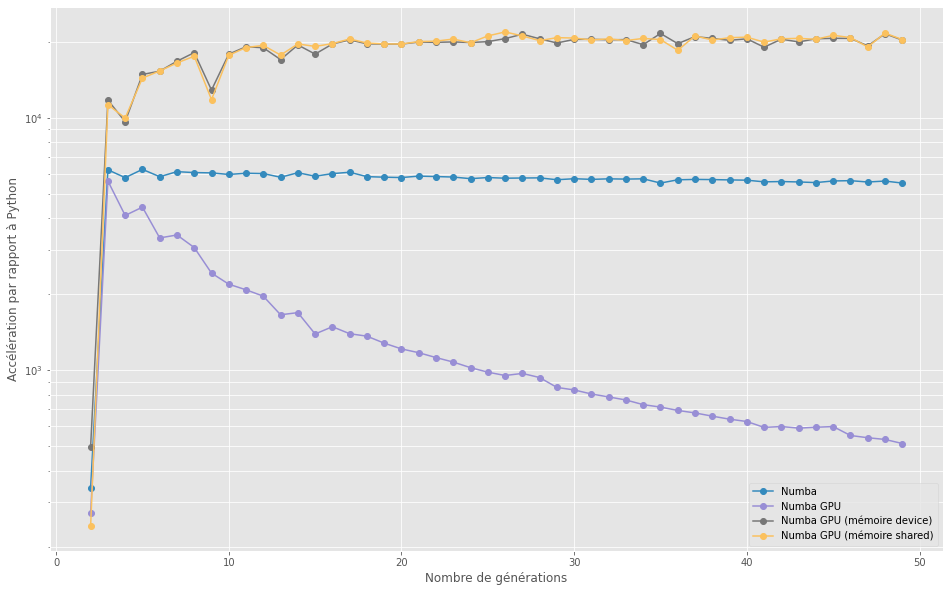

In [10]:
plt.figure(figsize=(16,10))    
plt.semilogy(generations,temps_calculs[0,:]/temps_calculs[1,:], marker="o",c="C1")
plt.semilogy(generations,temps_calculs[0,:]/temps_calculs[2,:], marker="o",c="C2")
plt.semilogy(generations,temps_calculs[0,:]/temps_calculs[3,:], marker="o",c="C3")
plt.semilogy(generations,temps_calculs[0,:]/temps_calculs[4,:], marker="o",c="C4")
plt.legend(("Numba","Numba GPU","Numba GPU (mémoire device)","Numba GPU (mémoire shared)"))
plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')
plt.xlabel("Nombre de générations")
plt.ylabel("Accélération par rapport à Python")
plt.show()